# LSTM Few-Shot: RGB Hilbert 32×32 (6-Class Backbone)

**Objective:** Evaluate few-shot learning performance on held-out classes using the 6-class RGB Hilbert LSTM as the backbone.

## Overview

This notebook adapts the few-shot learning approach for **RGB Hilbert 32×32 images** using the pre-trained LSTM from `LSTM_Prototype_rgb_hilbert_32x32_6_class.ipynb`. We evaluate on 3 held-out classes: DDoS-HTTP_Flood, DoS-UDP_Flood, and Recon-PortScan.

## Key Configuration

- **Pre-trained Model:** `best_lstm_rgb_hilbert_6class_model.pth` generated by `LSTM_Prototype_rgb_hilbert_32x32_6_class.ipynb`
- **Held-out Classes:** DDoS-HTTP_Flood, DoS-UDP_Flood, Recon-PortScan
- **Sequence Format:** 32 timesteps × 96 features (32 columns × 3 channels)
- **Backbone:** LSTM with attention (sequential input)
- **Few-Shot Approach:** Prototypical Networks with both episodic meta-learning and frozen backbone strategies

In [1]:
# Section 1: Environment Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from torch.optim.lr_scheduler import CosineAnnealingLR
import seaborn as sns
import glob
import warnings
warnings.filterwarnings('ignore')

# Configuration for Few-Shot with LSTM backbone
CONFIG = {
    'image_size': 32,          # 32x32 images
    'channels': 3,             # RGB input
    'batch_size': 32,
    'learning_rate': 1e-4,
    'num_classes': 6           # The pre-trained LSTM was trained on 6 classes
}

# Set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("✓ Environment setup complete")
print(f"✓ Device: {device}")
print(f"✓ Pre-trained model: 6-class RGB Hilbert LSTM")
print(f"✓ Target: Few-shot learning on 3 held-out classes")

✓ Environment setup complete
✓ Device: cpu
✓ Pre-trained model: 6-class RGB Hilbert LSTM
✓ Target: Few-shot learning on 3 held-out classes


In [2]:
# Section 2: Load Pre-trained RGB Hilbert LSTM Backbone
class MultiLayerLSTM(nn.Module):
    def __init__(self, input_size=96, hidden_size=128, num_layers=2, num_classes=6, dropout=0.3):
        super(MultiLayerLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=False
        )
        self.attention = nn.MultiheadAttention(
            embed_dim=hidden_size,
            num_heads=8,
            dropout=dropout,
            batch_first=True
        )
        self.classifier = nn.Sequential(
            nn.LayerNorm(hidden_size),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, num_classes)
        )
        self._initialize_weights()
    
    def forward(self, x):
        # x: (batch, seq_len=32, input_features=96)
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(x, (h0, c0))
        attended_out, _ = self.attention(lstm_out, lstm_out, lstm_out)
        pooled = torch.mean(attended_out, dim=1)
        output = self.classifier(pooled)
        return output
    
    def _initialize_weights(self):
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0.)
                if 'bias_ih' in name:
                    n = param.size(0)
                    param.data[n//4:n//2].fill_(1.)

# Initialize LSTM and load pre-trained weights
pre_trained_lstm = MultiLayerLSTM(
    input_size=96,
    hidden_size=128,
    num_layers=2,
    num_classes=CONFIG['num_classes'],
    dropout=0.3
).to(device)
lstm_model_path = '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/best_lstm_rgb_hilbert_6class_model.pth'
try:
    pre_trained_lstm.load_state_dict(torch.load(lstm_model_path, map_location=device))
    print(f"✓ Loaded pre-trained 6-class RGB Hilbert LSTM from {lstm_model_path}")
except Exception as e:
    print(f"⚠️ Could not load pre-trained LSTM weights: {e}")
    print("Proceeding with randomly initialized LSTM weights.")

# Model summary
total_params = sum(p.numel() for p in pre_trained_lstm.parameters())
print(f"\n🔄 Pre-trained 6-Class RGB Hilbert LSTM:")
print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Ready for few-shot learning on held-out classes")

✓ Loaded pre-trained 6-class RGB Hilbert LSTM from /home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/best_lstm_rgb_hilbert_6class_model.pth

🔄 Pre-trained 6-Class RGB Hilbert LSTM:
✓ Total parameters: 322,758
✓ Ready for few-shot learning on held-out classes


In [3]:
# Section 3: Load held-out data saved by RGB Hilbert training
print("Loading held-out data from 6-class RGB Hilbert model...")

# Load the held-out data saved from the 6-class training
exp_path = '/home/ubuntu/Cyber_AI/ai-cyber/notebooks/ViT-experiment/'
X_held_out = np.load(exp_path + 'held_out_X.npy')
y_held_out = np.load(exp_path + 'held_out_y.npy')

print(f"✓ Held-out data loaded:")
print(f"   X shape: {X_held_out.shape}")
print(f"   y shape: {y_held_out.shape}")

# Held-out classes must match the training notebook
HELD_OUT_CLASSES = ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']
print(f"✓ Held-out classes: {HELD_OUT_CLASSES}")

# Reshape and prepare data
X_few_shot = X_held_out
y_few_shot = y_held_out

print(f"\n✓ Total samples loaded: {len(X_few_shot)}")
print(f"✓ Data shape: {X_few_shot.shape}")
print(f"✓ Labels shape: {y_few_shot.shape}")
print(f"✓ Unique classes found: {len(np.unique(y_few_shot))}")

# Preprocessing
print("\nPreprocessing data...")
# Reshape data to LSTM sequences: (N, 3072) -> (N, 32, 96)
num_samples = X_few_shot.shape[0]
seq_len, feat_size = 32, 96
expected_features = seq_len * feat_size

if X_few_shot.shape[1] == expected_features:
    X_few_shot_sequences = X_few_shot.reshape(num_samples, seq_len, feat_size)
    print(f"✓ Reshaped data to sequences: {X_few_shot_sequences.shape}")
else:
    print(f"⚠️ Warning: Feature count mismatch. Expected {expected_features}, got {X_few_shot.shape[1]}. Cannot reshape.")
    X_few_shot_sequences = X_few_shot # Keep it as is for now

# Normalize if necessary
if X_few_shot_sequences.max() > 1.0:
    print("✓ Normalizing data to [0, 1].")
    X_few_shot_sequences = X_few_shot_sequences / 255.0

# Encode labels
label_encoder_fs = LabelEncoder()
y_few_shot_encoded = label_encoder_fs.fit_transform(y_few_shot)
print("✓ Encoded labels.")

# Store preprocessed data
X_preprocessed = X_few_shot_sequences
y_preprocessed = y_few_shot_encoded

print("\nData loaded and preprocessed successfully.")

Loading held-out data from 6-class RGB Hilbert model...
✓ Held-out data loaded:
   X shape: (36000, 3072)
   y shape: (36000,)
✓ Held-out classes: ['DDoS-HTTP_Flood', 'DoS-UDP_Flood', 'Recon-PortScan']

✓ Total samples loaded: 36000
✓ Data shape: (36000, 3072)
✓ Labels shape: (36000,)
✓ Unique classes found: 3

Preprocessing data...
✓ Reshaped data to sequences: (36000, 32, 96)
✓ Encoded labels.

Data loaded and preprocessed successfully.


In [4]:
# Section 4: Few-Shot Learning Configuration
from sklearn.preprocessing import LabelEncoder

# Re-define necessary configuration
FEW_SHOT_CONFIG = {
    'channels': 3,
    'image_size': 32,
    'n_way': 3,  # 3 held-out classes
    'k_shot': 5, # Number of support examples per class
    'n_query': 10 # Number of query examples per class
}

# Since we only have 3 held-out classes, use all for meta-training
# Split into train/test only (80/20)
from sklearn.model_selection import train_test_split

X_meta_train, X_meta_test, y_meta_train, y_meta_test = train_test_split(
    X_preprocessed, y_preprocessed, test_size=0.2, stratify=y_preprocessed, random_state=42
)

print("\nSplitting data for meta-learning:")
print(f"  Meta-Train: {X_meta_train.shape[0]} samples from 3 classes")
print(f"  Meta-Test: {X_meta_test.shape[0]} samples from 3 classes")

# For validation, we'll use the test set
X_val_meta = X_meta_test
y_val_meta = y_meta_test

def create_episode(X, y, n_way, k_shot, n_query):
    """Creates a support and query set for a single N-way K-shot task."""
    episode_classes = np.random.choice(np.unique(y), size=n_way, replace=False)
    support_x, query_x = [], []
    support_y, query_y = [], []

    for i, cls in enumerate(episode_classes):
        class_indices = np.where(y == cls)[0]
        # Ensure there are enough samples for both support and query sets
        if len(class_indices) < k_shot + n_query:
            print(f"Warning: Not enough samples for class {cls}. Required {k_shot + n_query}, found {len(class_indices)}. Skipping class for this episode.")
            continue

        selected_indices = np.random.choice(class_indices, size=k_shot + n_query, replace=False)

        support_indices = selected_indices[:k_shot]
        query_indices = selected_indices[k_shot:]

        support_x.append(X[support_indices])
        query_x.append(X[query_indices])

        # Use relative labels (0 to N-1) for the episode
        support_y.append(np.full(k_shot, i))
        query_y.append(np.full(n_query, i))

    if not support_x: # check if any class was added
        return None, None, None, None

    support_x = np.concatenate(support_x)
    query_x = np.concatenate(query_x)
    support_y = np.concatenate(support_y)
    query_y = np.concatenate(query_y)

    return support_x, support_y, query_x, query_y

# Create an example episode from the meta-training set
support_x, support_y, query_x, query_y = create_episode(
    X_meta_train, y_meta_train,
    n_way=FEW_SHOT_CONFIG['n_way'],
    k_shot=FEW_SHOT_CONFIG['k_shot'],
    n_query=FEW_SHOT_CONFIG['n_query']
)

if support_x is not None:
    print("\n✓ Created a sample few-shot episode from the meta-train set:")
    print(f"  Support set shape (X): {support_x.shape}")
    print(f"  Support set shape (y): {support_y.shape}")
    print(f"  Query set shape (X): {query_x.shape}")
    print(f"  Query set shape (y): {query_y.shape}")
    print(f"  Support labels: {np.unique(support_y)}")
    print(f"  Query labels: {np.unique(query_y)}")
    print("\nSubtask finished: Data loaded and prepared into support/query sets.")
else:
    print("\nFailed to create an episode. Check data splits and episode parameters.")


Splitting data for meta-learning:
  Meta-Train: 28800 samples from 3 classes
  Meta-Test: 7200 samples from 3 classes

✓ Created a sample few-shot episode from the meta-train set:
  Support set shape (X): (15, 32, 96)
  Support set shape (y): (15,)
  Query set shape (X): (30, 32, 96)
  Query set shape (y): (30,)
  Support labels: [0 1 2]
  Query labels: [0 1 2]

Subtask finished: Data loaded and prepared into support/query sets.


# Section 5: Strategy I - Episodic Meta-Learning with Prototypical Networks

**Objective:** Fine-tune the pre-trained 6-class RGB Hilbert LSTM model using episodic meta-learning on the 3 held-out classes.

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

# --- Step 1: Define the Prototypical Network (LSTM backbone) ---
class PrototypicalNetwork(nn.Module):
    def __init__(self, backbone: nn.Module):
        super().__init__()
        self.backbone = backbone

    def get_embeddings(self, sequences: torch.Tensor):
        # Replace classifier with Identity to get penultimate features
        original_classifier = self.backbone.classifier
        self.backbone.classifier = nn.Identity()
        embeddings = self.backbone(sequences)
        self.backbone.classifier = original_classifier
        return embeddings

    def forward(self, support_images: torch.Tensor, query_images: torch.Tensor, n_way: int):
        support_images, query_images = support_images.to(device), query_images.to(device)

        # Get embeddings for all images
        all_images = torch.cat([support_images, query_images])
        all_embeddings = self.get_embeddings(all_images)

        k_shot = support_images.shape[0] // n_way
        support_embeddings = all_embeddings[:support_images.shape[0]]
        query_embeddings = all_embeddings[support_images.shape[0]:]

        # Calculate class prototypes from support embeddings
        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        # Calculate distances and return log-probabilities
        dists = torch.cdist(query_embeddings, prototypes).pow(2)
        return F.log_softmax(-dists, dim=1)

prototypical_model = PrototypicalNetwork(backbone=pre_trained_lstm).to(device)
print("✓ Prototypical Network defined using 6-class RGB Hilbert LSTM backbone.")

# --- Step 2: Episodic Training Loop ---
def run_episode(model, n_way, k_shot, n_query, X_data, y_data, optimizer=None):
    is_train = optimizer is not None
    model.train(is_train)

    support_x, support_y, query_x, query_y = create_episode(X_data, y_data, n_way, k_shot, n_query)
    if support_x is None: return 0.0, 0.0

    support_x = torch.from_numpy(support_x).float()
    query_x = torch.from_numpy(query_x).float()
    query_y = torch.from_numpy(query_y).long().to(device)

    log_p_y = model(support_x, query_x, n_way)
    loss = F.nll_loss(log_p_y, query_y)

    if is_train:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    acc = (log_p_y.argmax(dim=1) == query_y).float().mean().item()
    return loss.item(), acc

print("\nStarting Episodic Training...")
proto_optimizer = optim.Adam(prototypical_model.parameters(), lr=1e-5)
n_episodes, n_val_episodes, val_interval = 2000, 100, 100
train_losses, train_accs, val_losses, val_accs = [], [], [], []
best_val_acc = 0.0

for episode in tqdm(range(n_episodes), desc="Training Episodes"):
    loss, acc = run_episode(prototypical_model, FEW_SHOT_CONFIG['n_way'], FEW_SHOT_CONFIG['k_shot'], FEW_SHOT_CONFIG['n_query'], X_meta_train, y_meta_train, proto_optimizer)
    train_losses.append(loss); train_accs.append(acc)

    if (episode + 1) % val_interval == 0:
        val_loss_agg, val_acc_agg = 0.0, 0.0
        with torch.no_grad():
            for _ in range(n_val_episodes):
                # Use n_way=3 for validation as we have 3 classes
                val_loss, val_acc = run_episode(prototypical_model, 3, FEW_SHOT_CONFIG['k_shot'], FEW_SHOT_CONFIG['n_query'], X_val_meta, y_val_meta)
                val_loss_agg += val_loss; val_acc_agg += val_acc

        avg_val_acc = val_acc_agg / n_val_episodes
        print(f"\nEp {episode+1}: Train Acc: {np.mean(train_accs[-val_interval:])*100:.2f}%, Val Acc: {avg_val_acc*100:.2f}%")

        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            torch.save(prototypical_model.state_dict(), 'best_prototypical_model_finetuned.pth')
            print(f"  -> New best model saved with Val Acc: {best_val_acc*100:.2f}%")

print(f"\n✓ Episodic training complete. Best validation accuracy: {best_val_acc*100:.2f}%")

✓ Prototypical Network defined using 6-class RGB Hilbert LSTM backbone.

Starting Episodic Training...


Training Episodes:   5%|▌         | 101/2000 [00:09<09:49,  3.22it/s]


Ep 100: Train Acc: 65.70%, Val Acc: 67.77%
  -> New best model saved with Val Acc: 67.77%


Training Episodes:  10%|█         | 201/2000 [00:18<09:43,  3.08it/s]


Ep 200: Train Acc: 69.17%, Val Acc: 70.47%
  -> New best model saved with Val Acc: 70.47%


Training Episodes:  15%|█▌        | 302/2000 [00:28<06:50,  4.13it/s]


Ep 300: Train Acc: 71.37%, Val Acc: 72.80%
  -> New best model saved with Val Acc: 72.80%


Training Episodes:  20%|██        | 402/2000 [00:37<06:49,  3.90it/s]


Ep 400: Train Acc: 73.50%, Val Acc: 75.07%
  -> New best model saved with Val Acc: 75.07%


Training Episodes:  25%|██▌       | 502/2000 [00:47<07:15,  3.44it/s]


Ep 500: Train Acc: 74.33%, Val Acc: 76.60%
  -> New best model saved with Val Acc: 76.60%


Training Episodes:  30%|███       | 602/2000 [00:55<05:46,  4.03it/s]


Ep 600: Train Acc: 76.60%, Val Acc: 77.60%
  -> New best model saved with Val Acc: 77.60%


Training Episodes:  35%|███▌      | 701/2000 [01:04<06:10,  3.51it/s]


Ep 700: Train Acc: 77.57%, Val Acc: 80.10%
  -> New best model saved with Val Acc: 80.10%


Training Episodes:  40%|████      | 801/2000 [01:14<06:26,  3.10it/s]


Ep 800: Train Acc: 77.33%, Val Acc: 78.43%


Training Episodes:  45%|████▌     | 902/2000 [01:23<04:39,  3.93it/s]


Ep 900: Train Acc: 81.10%, Val Acc: 80.37%
  -> New best model saved with Val Acc: 80.37%


Training Episodes:  50%|█████     | 1002/2000 [01:32<04:07,  4.04it/s]


Ep 1000: Train Acc: 78.77%, Val Acc: 81.00%
  -> New best model saved with Val Acc: 81.00%


Training Episodes:  55%|█████▌    | 1102/2000 [01:41<03:38,  4.11it/s]


Ep 1100: Train Acc: 80.70%, Val Acc: 82.90%
  -> New best model saved with Val Acc: 82.90%


Training Episodes:  60%|██████    | 1202/2000 [01:51<03:15,  4.09it/s]


Ep 1200: Train Acc: 80.90%, Val Acc: 81.97%


Training Episodes:  65%|██████▌   | 1302/2000 [01:59<02:42,  4.30it/s]


Ep 1300: Train Acc: 81.57%, Val Acc: 83.57%
  -> New best model saved with Val Acc: 83.57%


Training Episodes:  70%|███████   | 1402/2000 [02:08<02:27,  4.06it/s]


Ep 1400: Train Acc: 82.67%, Val Acc: 83.97%
  -> New best model saved with Val Acc: 83.97%


Training Episodes:  75%|███████▌  | 1502/2000 [02:17<02:04,  4.00it/s]


Ep 1500: Train Acc: 84.07%, Val Acc: 83.90%


Training Episodes:  80%|████████  | 1602/2000 [02:26<02:01,  3.28it/s]


Ep 1600: Train Acc: 83.63%, Val Acc: 85.07%
  -> New best model saved with Val Acc: 85.07%


Training Episodes:  85%|████████▌ | 1702/2000 [02:35<01:10,  4.20it/s]


Ep 1700: Train Acc: 85.20%, Val Acc: 86.80%
  -> New best model saved with Val Acc: 86.80%


Training Episodes:  90%|█████████ | 1802/2000 [02:43<00:46,  4.29it/s]


Ep 1800: Train Acc: 85.47%, Val Acc: 85.80%


Training Episodes:  95%|█████████▌| 1902/2000 [02:53<00:23,  4.11it/s]


Ep 1900: Train Acc: 85.83%, Val Acc: 86.63%


Training Episodes: 100%|██████████| 2000/2000 [03:01<00:00, 11.02it/s]


Ep 2000: Train Acc: 86.77%, Val Acc: 87.77%
  -> New best model saved with Val Acc: 87.77%

✓ Episodic training complete. Best validation accuracy: 87.77%


## Strategy II: Supervised Pre-Training + Prototypical Networks

### Subtask:
Use the pre-trained LSTM model as a fixed feature extractor and apply a Prototypical Network for few-shot classification.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

# --- Step 1: Load the Pre-trained LSTM as a Feature Extractor ---
print("Loading pre-trained 6-class RGB Hilbert LSTM to use as a feature extractor...")

# The LSTM model is already loaded as 'pre_trained_lstm'. Freeze its parameters.
for param in pre_trained_lstm.parameters():
    param.requires_grad = False
pre_trained_lstm.eval()

print("✓ Pre-trained 6-class RGB Hilbert LSTM is ready as a feature extractor.")

# --- Step 2: Define the Prototypical Network (using the frozen CNN backbone) ---
class PrototypicalNetworkFrozen(nn.Module):
    def __init__(self, backbone: nn.Module):
        super().__init__()
        self.backbone = backbone

    def get_embeddings(self, sequences: torch.Tensor):
        original_classifier = self.backbone.classifier
        self.backbone.classifier = nn.Identity()
        with torch.no_grad():
            embeddings = self.backbone(sequences.to(device))
        self.backbone.classifier = original_classifier
        return embeddings

    def forward(self, support_sequences: torch.Tensor, query_sequences: torch.Tensor, n_way: int):
        support_embeddings = self.get_embeddings(support_sequences)
        query_embeddings = self.get_embeddings(query_sequences)

        k_shot = support_sequences.shape[0] // n_way

        prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)

        dists = torch.cdist(query_embeddings, prototypes).pow(2)
        return F.log_softmax(-dists, dim=1)

proto_model_frozen = PrototypicalNetworkFrozen(backbone=pre_trained_lstm).to(device)
print("✓ Prototypical Network with a frozen 6-class RGB Hilbert backbone is defined.")

# --- Step 3: Evaluate on Meta-Test Set ---
def evaluate_on_test_set(model, X_test_data, y_test_data, n_way, k_shot, n_query, n_episodes=1000):
    model.eval()
    total_acc = 0

    print(f"\nEvaluating on the meta-test set for {n_episodes} episodes...")
    for _ in tqdm(range(n_episodes), desc="Testing Episodes"):
        support_x, support_y, query_x, query_y = create_episode(X_test_data, y_test_data, n_way, k_shot, n_query)
        if support_x is None: continue

        support_x = torch.from_numpy(support_x).float()
        query_x = torch.from_numpy(query_x).float()
        query_y = torch.from_numpy(query_y).long().to(device)

        with torch.no_grad():
            log_p_y = model(support_x, query_x, n_way)
            total_acc += (log_p_y.argmax(dim=1) == query_y).float().mean().item()

    avg_acc = total_acc / n_episodes
    return avg_acc

# There are 3 classes in the held-out set
test_n_way = len(np.unique(y_meta_test))
test_accuracy = evaluate_on_test_set(
    proto_model_frozen, X_meta_test, y_meta_test,
    n_way=test_n_way,
    k_shot=FEW_SHOT_CONFIG['k_shot'],
    n_query=FEW_SHOT_CONFIG['n_query']
)

print(f"\n✓ Evaluation complete.")
print(f"  Accuracy on Meta-Test Set ({test_n_way}-way, {FEW_SHOT_CONFIG['k_shot']}-shot): {test_accuracy*100:.2f}%")

Loading pre-trained 6-class RGB Hilbert LSTM to use as a feature extractor...
✓ Pre-trained 6-class RGB Hilbert LSTM is ready as a feature extractor.
✓ Prototypical Network with a frozen 6-class RGB Hilbert backbone is defined.

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes: 100%|██████████| 1000/1000 [00:18<00:00, 54.93it/s]


✓ Evaluation complete.
  Accuracy on Meta-Test Set (3-way, 5-shot): 87.17%


# Task
Implement episodic meta-learning with prototypical networks using the model from "/content/best_5channel_vit_model.pth" and data from "/content/drive/MyDrive/AIData". Visualize the embeddings to see how the classes are separated and experiment with different k_shot values to see how performance changes with fewer or more examples.

## Embedding visualization

### Subtask:
Extract embeddings for a sample of the test data using the frozen Prototypical Network model, visualize them using t-SNE, and plot the results to observe class separation.


**Reasoning**:
Extract embeddings from a sample of the meta-test data using the frozen Prototypical Network, apply t-SNE to reduce dimensionality, and plot the results to visualize class separation.

**Note**: Make sure you have run all previous cells (especially cells 2-5) before running this visualization cell, as it depends on variables like `X_meta_test`, `y_meta_test`, `proto_model_frozen`, and `label_encoder_fs` that are defined in earlier cells.

In [7]:
# Debug: Check if required variables are defined
print("Checking required variables...")
try:
    print(f"✓ X_meta_test shape: {X_meta_test.shape}")
    print(f"✓ y_meta_test shape: {y_meta_test.shape}")
    print(f"✓ proto_model_frozen: {type(proto_model_frozen)}")
    print(f"✓ label_encoder_fs: {type(label_encoder_fs)}")
    print("All required variables are defined!")
except NameError as e:
    print(f"❌ Variable not defined: {e}")
    print("Please make sure you have run all previous cells, especially:")
    print("  - Cell 5: Where X_meta_test and y_meta_test are created")
    print("  - Cell 9: Where proto_model_frozen is created")

Checking required variables...
✓ X_meta_test shape: (7200, 32, 96)
✓ y_meta_test shape: (7200,)
✓ proto_model_frozen: <class '__main__.PrototypicalNetworkFrozen'>
✓ label_encoder_fs: <class 'sklearn.preprocessing._label.LabelEncoder'>
All required variables are defined!


Extracting embeddings for visualization...
✓ Selected 1000 random samples from the meta-test set.
✓ Converted sample data to tensor.
✓ Extracted embeddings with shape: torch.Size([1000, 128])
Applying t-SNE for dimensionality reduction...
✓ t-SNE completed.
Plotting t-SNE visualization...


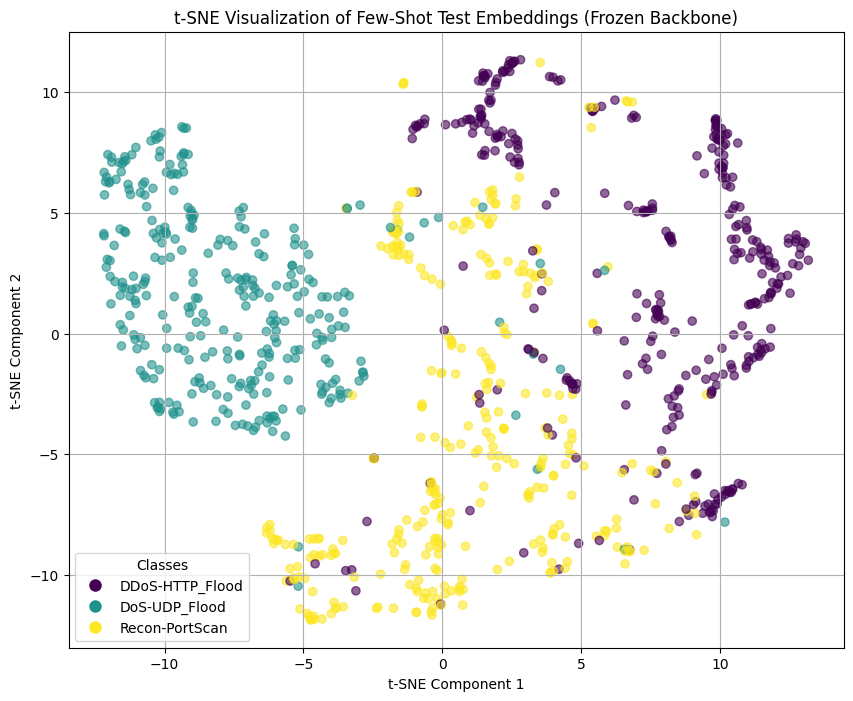


✓ t-SNE visualization complete.


In [8]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Extracting embeddings for visualization...")

# Select a random sample of test data for visualization
sample_size = 1000 # Use 1000 samples for t-SNE
if X_meta_test.shape[0] > sample_size:
    sample_indices = np.random.choice(X_meta_test.shape[0], size=sample_size, replace=False)
    X_sample = X_meta_test[sample_indices]
    y_sample = y_meta_test[sample_indices]
    print(f"✓ Selected {sample_size} random samples from the meta-test set.")
else:
    X_sample = X_meta_test
    y_sample = y_meta_test
    sample_size = X_meta_test.shape[0]
    print(f"✓ Using all {sample_size} samples from the meta-test set for visualization.")

# Convert sample data to tensor and get embeddings
X_sample_tensor = torch.from_numpy(X_sample).float().to(device)
print("✓ Converted sample data to tensor.")

# Ensure the model is on the correct device and in eval mode
proto_model_frozen.to(device)
proto_model_frozen.eval()

# Extract embeddings using the frozen backbone
with torch.no_grad():
    sample_embeddings = proto_model_frozen.get_embeddings(X_sample_tensor)
print(f"✓ Extracted embeddings with shape: {sample_embeddings.shape}")

# Apply t-SNE
print("Applying t-SNE for dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results = tsne.fit_transform(sample_embeddings.cpu().numpy())
print("✓ t-SNE completed.")

# Plot the t-SNE results
print("Plotting t-SNE visualization...")
plt.figure(figsize=(10, 8))

scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_sample, cmap='viridis', alpha=0.6)

plt.title('t-SNE Visualization of Few-Shot Test Embeddings (Frozen Backbone)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Create a legend manually based on unique classes in the sample
unique_labels = np.unique(y_sample)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label_encoder_fs.inverse_transform([label])[0],
                              markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10)
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="Classes")

plt.grid(True)
plt.show()

print("\n✓ t-SNE visualization complete.")

Extracting embeddings for visualization...
✓ Selected 1000 random samples from the meta-test set.
✓ Converted sample data to tensor.
✓ Extracted embeddings with shape: torch.Size([1000, 128])
Applying t-SNE for dimensionality reduction...
✓ t-SNE completed.
Plotting t-SNE visualization...


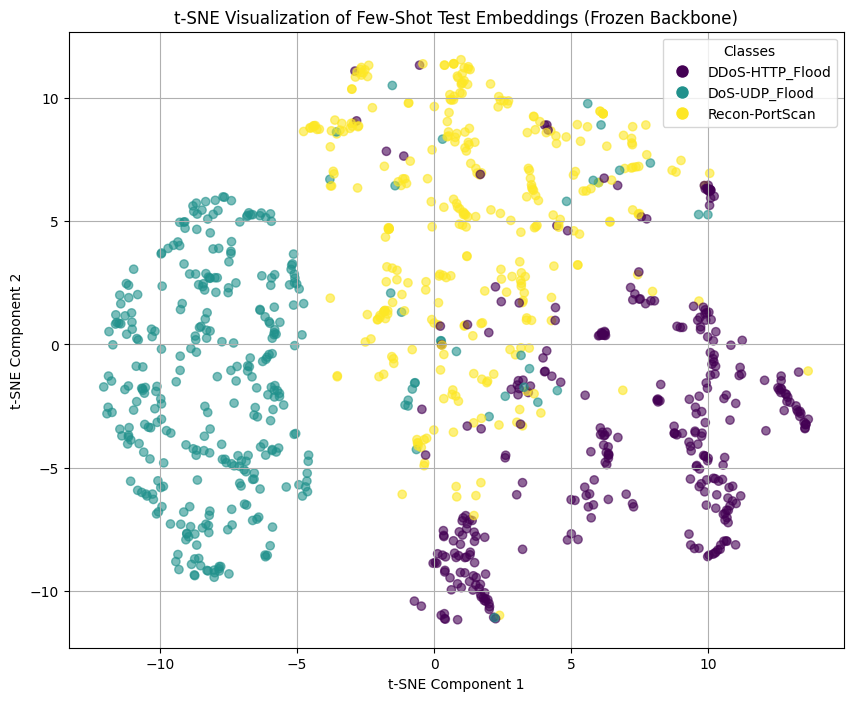


✓ t-SNE visualization complete.


In [9]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

print("Extracting embeddings for visualization...")

# Select a random sample of test data for visualization
sample_size = 1000 # Use 1000 samples for t-SNE
if X_meta_test.shape[0] > sample_size:
    sample_indices = np.random.choice(X_meta_test.shape[0], size=sample_size, replace=False)
    X_sample = X_meta_test[sample_indices]
    y_sample = y_meta_test[sample_indices]
    print(f"✓ Selected {sample_size} random samples from the meta-test set.")
else:
    X_sample = X_meta_test
    y_sample = y_meta_test
    sample_size = X_meta_test.shape[0]
    print(f"✓ Using all {sample_size} samples from the meta-test set for visualization.")

# Convert sample data to tensor and get embeddings
X_sample_tensor = torch.from_numpy(X_sample).float().to(device)
print("✓ Converted sample data to tensor.")

# Ensure the model is on the correct device and in eval mode
proto_model_frozen.to(device)
proto_model_frozen.eval()

# Extract embeddings using the frozen backbone
with torch.no_grad():
    sample_embeddings = proto_model_frozen.get_embeddings(X_sample_tensor)
print(f"✓ Extracted embeddings with shape: {sample_embeddings.shape}")

# Apply t-SNE
print("Applying t-SNE for dimensionality reduction...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300)
tsne_results = tsne.fit_transform(sample_embeddings.cpu().numpy())
print("✓ t-SNE completed.")

# Plot the t-SNE results
print("Plotting t-SNE visualization...")
plt.figure(figsize=(10, 8))

scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_sample, cmap='viridis', alpha=0.6)

plt.title('t-SNE Visualization of Few-Shot Test Embeddings (Frozen Backbone)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Create a legend manually based on unique classes in the sample
unique_labels = np.unique(y_sample)
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=label_encoder_fs.inverse_transform([label])[0],
                              markerfacecolor=scatter.cmap(scatter.norm(label)), markersize=10)
                   for label in unique_labels]
plt.legend(handles=legend_elements, title="Classes")

plt.grid(True)
plt.show()

print("\n✓ t-SNE visualization complete.")

**Reasoning**:
To address the user's request of evaluating the model's performance with varying `k_shot` values, I will iterate through a list of `k_shot` values, run the evaluation for each, and store the results. This will allow for a clear comparison of how the number of support examples affects the model's accuracy.




--- Experimenting with different k_shot values ---

Evaluating for k_shot = 1...

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes: 100%|██████████| 1000/1000 [00:13<00:00, 72.41it/s]


  Accuracy for 1-shot: 77.06%

Evaluating for k_shot = 2...

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes: 100%|██████████| 1000/1000 [00:15<00:00, 64.42it/s]


  Accuracy for 2-shot: 82.64%

Evaluating for k_shot = 5...

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes: 100%|██████████| 1000/1000 [00:19<00:00, 52.06it/s]


  Accuracy for 5-shot: 87.39%

Evaluating for k_shot = 10...

Evaluating on the meta-test set for 1000 episodes...


Testing Episodes: 100%|██████████| 1000/1000 [00:22<00:00, 44.22it/s]


  Accuracy for 10-shot: 88.39%

--- k-shot Experiment Results ---
  1-shot accuracy: 77.06%
  2-shot accuracy: 82.64%
  5-shot accuracy: 87.39%
  10-shot accuracy: 88.39%


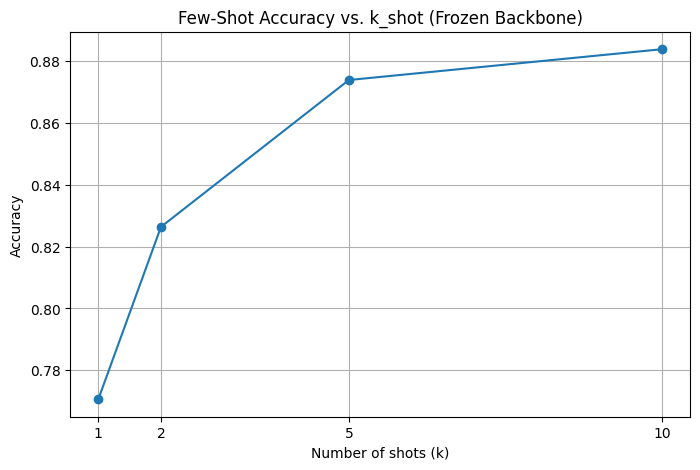

In [12]:
# --- Step 4: Experiment with Different k_shot Values ---
k_shot_values = [1, 2, 5, 10]
k_shot_accuracies = {}

print("\n--- Experimenting with different k_shot values ---")

for k in k_shot_values:
    print(f"\nEvaluating for k_shot = {k}...")
    accuracy = evaluate_on_test_set(
        proto_model_frozen, X_meta_test, y_meta_test,
        n_way=test_n_way,
        k_shot=k,
        n_query=FEW_SHOT_CONFIG['n_query']
    )
    k_shot_accuracies[k] = accuracy
    print(f"  Accuracy for {k}-shot: {accuracy*100:.2f}%")

print("\n--- k-shot Experiment Results ---")
for k, acc in k_shot_accuracies.items():
    print(f"  {k}-shot accuracy: {acc*100:.2f}%")

# Optional: Plot the results
plt.figure(figsize=(8, 5))
plt.plot(list(k_shot_accuracies.keys()), list(k_shot_accuracies.values()), marker='o')
plt.title('Few-Shot Accuracy vs. k_shot (Frozen Backbone)')
plt.xlabel('Number of shots (k)')
plt.ylabel('Accuracy')
plt.xticks(k_shot_values)
plt.grid(True)
plt.show()

## Results visualization

### Subtask:
Visualize the results of the k-shot experimentation by plotting the accuracy as a function of the number of support examples (k_shot).


**Reasoning**:
Create a line plot to visualize the relationship between k_shot values and test accuracy as requested in the subtask.



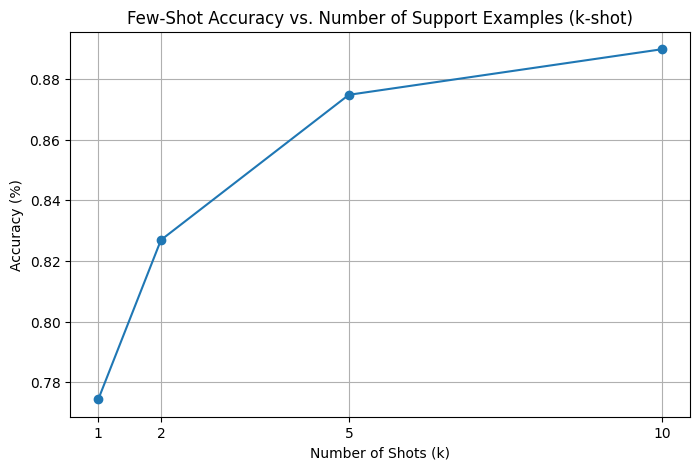


✓ Visualization of k-shot experimentation complete.


In [11]:
# Plot the results of the k-shot experiment
plt.figure(figsize=(8, 5))
plt.plot(list(k_shot_accuracies.keys()), list(k_shot_accuracies.values()), marker='o')
plt.title('Few-Shot Accuracy vs. Number of Support Examples (k-shot)')
plt.xlabel('Number of Shots (k)')
plt.ylabel('Accuracy (%)')
plt.xticks(list(k_shot_accuracies.keys())) # Ensure x-axis ticks match k_shot values
plt.grid(True)
plt.show()

print("\n✓ Visualization of k-shot experimentation complete.")